In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import warnings
import cProfile

from time import time

from astropy.stats import sigma_clip
from astropy.table import Table, Column, vstack
from scipy.ndimage.filters import gaussian_filter

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astroML.stats import binned_statistic_2d

from asap import io
from asap import smf 
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

plt.rc('text', usetex=True)

## Halo mass trend over the aperture mass plane

In [2]:
test_dir = '../model/'
model_str = 'final_6'

# The configuration file
config_file = os.path.join(test_dir, 'asap_test_%s.yaml' % model_str)

# The results of the final sampling process
result_file = os.path.join(test_dir, 'asap_test_%s_sample.npz' % model_str)

# Initialize the model, load the data
cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)

# Load in the final sampling results
(mod_result_samples, 
 mod_result_chains, 
 mod_result_lnprob, 
 mod_result_best, _, _) = io.load_npz_results(result_file)

_, n_step, n_dim = mod_result_chains.shape

mod_result_best = np.nanmean(mod_result_chains[:, -int(n_step * 0.1):, :].reshape([-1, n_dim]), axis=0)

# Predict the stellar mass in inner and outer apertures
logms_inn, logms_tot, sig_logms, mask_use = predict_mstar_basic(
    um_data['um_mock'], mod_result_best, min_logms=10.5,
    logmh_col=cfg['um']['logmh_col'], min_scatter=cfg['um']['min_scatter'],
    pivot=cfg['um']['pivot_logmh'])

# Predict the SMFs and DeltaSigma profiles
um_smf_tot, um_smf_inn, um_dsigma = make_model_predictions(
    mod_result_best, cfg, obs_data, um_data)

# Check the likelihood for SMF and DeltaSigma profiles
lnlike_smf, lnlike_dsigma = ln_likelihood(
    mod_result_best, cfg, obs_data, um_data, sep_return=True)

# The useful part of the mock catalog
um_mock_use = um_data['um_mock'][mask_use]

print("\n# Best parameters: ", mod_result_best)
print("# ln(Likelihood) for SMFs   : %8.4f" % lnlike_smf)
print("# ln(Likelihood) for DSigma : %8.4f" % lnlike_dsigma)

print("\n", mod_result_best)

# Running model: asap_test_final_6
#    Will use emcee as sampler ...
#    Use   256 walkers with    snooker moves for   200 x  3 steps of burn-in
#    Use   256 walkers with        kde moves for  9000 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_short.npy
# DSigma results : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total 

### Only for central galaxies

/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:340: RuntimeWarning: Mean of empty slice
  null = statistic([])


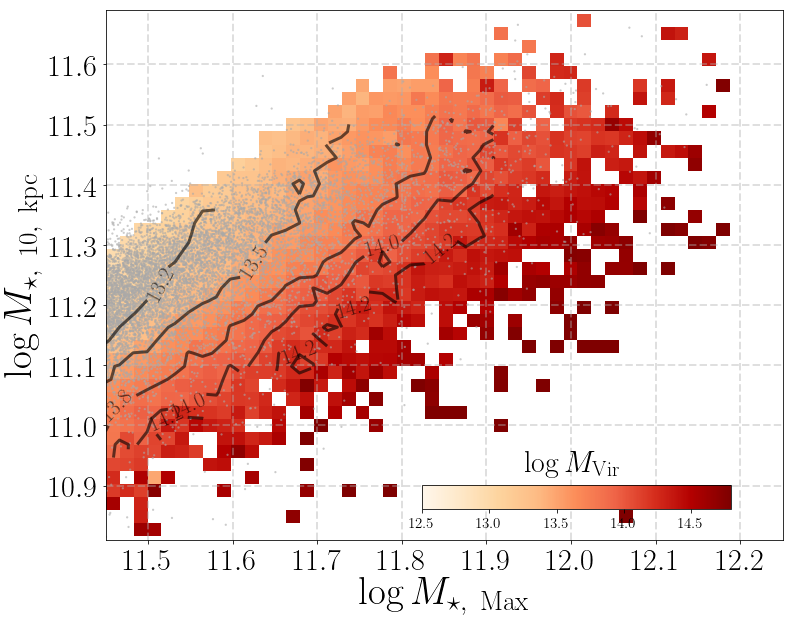

In [3]:
# Select galaxies to show
mask_mod = ((logms_tot >= 11.45) & (logms_tot <= 12.20) & 
            (logms_inn >= 10.65) & (logms_inn <= 11.70) & (um_mock_use['upid'] == -1))

fig_1 = plt.figure(figsize=(11, 8.5))
fig_1.subplots_adjust(left=0.14, right=0.995, bottom=0.13, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_1.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

# Color density plot that indicates the change of Mvir
x_arr = logms_tot[mask_mod]
y_arr = logms_inn[mask_mod]
z_arr = um_mock_use['logmh_vir'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmean, bins=(45, 40))

HM = ax1.imshow(z_stats.T, origin='lower', cmap='OrRd', extent=[
                    x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                vmin=12.5, vmax=14.80, aspect='auto', interpolation='nearest')

# Contours for iso-Mvir curves
CT = ax1.contour(x_edges[:-1], y_edges[:-1], gaussian_filter(z_stats.T, 0.2),
                 6, linewidths=3.0, colors='k', alpha=0.6,
                 levels=[13.2, 13.5, 13.8, 14.0, 14.2], extend='neither')
_ = ax1.clabel(CT, inline=1, fontsize=22, colors='k', fmt=r'$%4.1f$')

# Scatter plot for observed mass
x_arr = obs_data['mtot']
y_arr = obs_data['minn']
ax1.scatter(x_arr, y_arr, s=5, alpha=0.6, facecolor='darkgray', edgecolor='none')

# Colorbar
cax = fig_1.add_axes([0.54, 0.18, 0.39, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")

ax1.text(0.62, 0.12, r'$\log M_{\rm Vir}$', transform=ax1.transAxes, size=30)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.25)
_ = ax1.set_ylim(10.81, 11.69)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=39)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=39)

In [4]:
fig_1.savefig('fig/fig6_cen.pdf', dpi=120)

### Including satellites

/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:340: RuntimeWarning: Mean of empty slice
  null = statistic([])


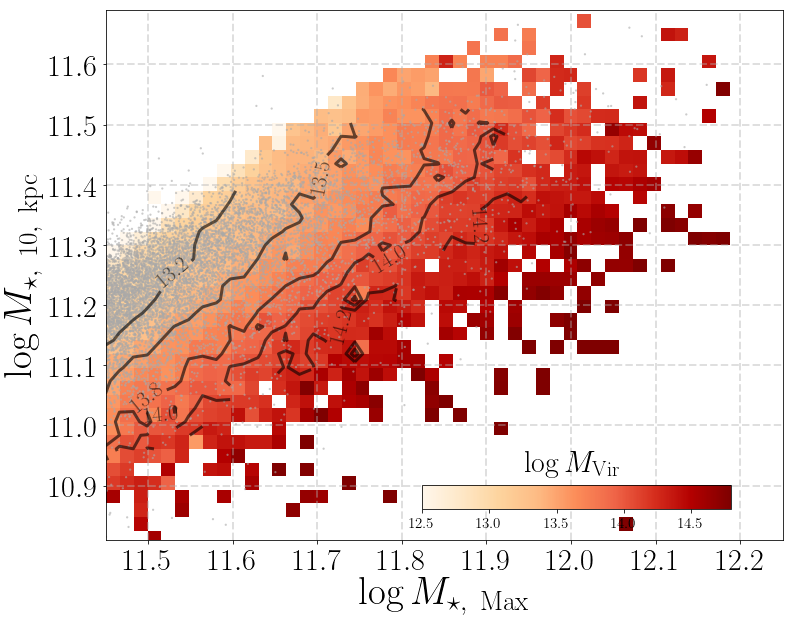

In [5]:
# Select galaxies to show
mask_mod = ((logms_tot >= 11.45) & (logms_tot <= 12.20) & 
            (logms_inn >= 10.65) & (logms_inn <= 11.70))

fig_1 = plt.figure(figsize=(11, 8.5))
fig_1.subplots_adjust(left=0.14, right=0.995, bottom=0.13, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_1.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

# Color density plot that indicates the change of Mvir
x_arr = logms_tot[mask_mod]
y_arr = logms_inn[mask_mod]
z_arr = um_mock_use['logmh_vir'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmean, bins=(45, 40))

HM = ax1.imshow(z_stats.T, origin='lower', cmap='OrRd', extent=[
                    x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                vmin=12.5, vmax=14.80, aspect='auto', interpolation='nearest')

# Contours for iso-Mvir curves
CT = ax1.contour(x_edges[:-1], y_edges[:-1], gaussian_filter(z_stats.T, 0.2),
                 6, linewidths=3.0, colors='k', alpha=0.6,
                 levels=[13.2, 13.5, 13.8, 14.0, 14.2], extend='neither')
_ = ax1.clabel(CT, inline=1, fontsize=22, colors='k', fmt=r'$%4.1f$')

# Scatter plot for observed mass
x_arr = obs_data['mtot']
y_arr = obs_data['minn']
ax1.scatter(x_arr, y_arr, s=5, alpha=0.6, facecolor='darkgray', edgecolor='none')

# Colorbar
cax = fig_1.add_axes([0.54, 0.18, 0.39, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")

ax1.text(0.62, 0.12, r'$\log M_{\rm Vir}$', transform=ax1.transAxes, size=30)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.25)
_ = ax1.set_ylim(10.81, 11.69)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=39)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=39)

### A slightly different figure for presentation

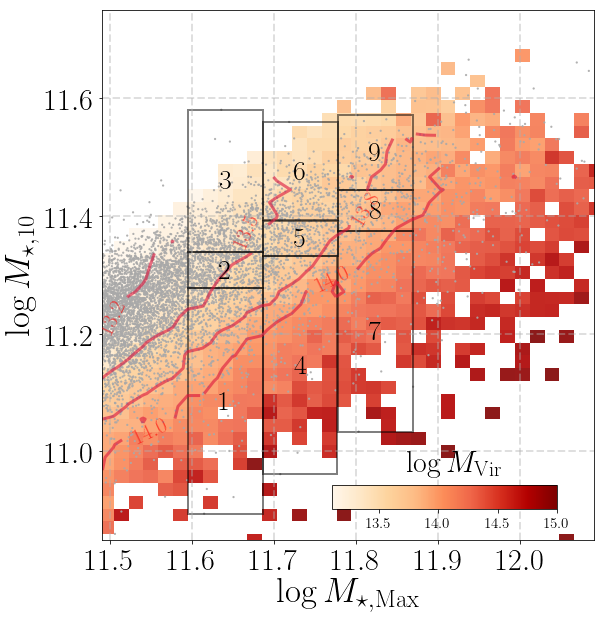

In [6]:
# Select galaxies to show
mask_mod = ((logms_tot >= 11.45) & (logms_tot <= 12.5) & 
            (logms_inn >= 10.65) & (logms_inn <= 11.70) & (um_mock_use['upid'] == -1))

fig_1 = plt.figure(figsize=(8.0, 8.5))
fig_1.subplots_adjust(left=0.14, right=0.995, bottom=0.13, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_1.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

# Color density plot that indicates the change of Mvir
x_arr = logms_tot[mask_mod]
y_arr = logms_inn[mask_mod]
z_arr = um_mock_use['logmh_vir'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmean, bins=(45, 40))

HM = ax1.imshow(z_stats.T, origin='lower', cmap='OrRd', 
                extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                vmin=13.1, vmax=15.00, aspect='auto', 
                interpolation='nearest', alpha=0.9)

# Contours for iso-Mvir curves
CT = ax1.contour(x_edges[:-1], y_edges[:-1], gaussian_filter(z_stats.T, 0.25),
                 6, linewidths=3, colors='crimson', alpha=0.6,
                 levels=[13.2, 13.5, 13.8, 14.0], extend='neither')

_ = ax1.clabel(CT, inline=1, fontsize=22, colors='r', fmt=r'$%4.1f$')

# Scatter plot for observed mass
x_arr = obs_data['mtot']
y_arr = obs_data['minn']
ax1.scatter(x_arr, y_arr, s=5, alpha=0.9, facecolor='darkgray', edgecolor='none')

# Colorbar
cax = fig_1.add_axes([0.54, 0.18, 0.39, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")

ax1.text(0.62, 0.12, r'$\log M_{\rm Vir}$', transform=ax1.transAxes, size=30)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

for ii in np.arange(9):
    obs_prof = obs_data['wl_dsigma'][ii]
    ax1.add_patch(
        patches.Rectangle(
            (obs_prof['min_logm1'], obs_prof['min_logm2']),
            (obs_prof['max_logm1'] - obs_prof['min_logm1']),
            (obs_prof['max_logm2'] - obs_prof['min_logm2']), 
            alpha=0.5, facecolor='none', edgecolor='k', linewidth=2))
    ax1.text((obs_prof['max_logm1'] + obs_prof['min_logm1']) / 2.0, 
             (obs_prof['max_logm2'] + obs_prof['min_logm2']) / 2.0,
             r"$%d$" % (ii + 1), 
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=28, color='k', alpha=1.0)

_ = ax1.set_xlim(11.49, 12.09)
_ = ax1.set_ylim(10.85, 11.75)

_ = ax1.set_xlabel(r'$\log M_{\star, \rm Max}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star, 10}$', fontsize=35)